<a href="https://colab.research.google.com/github/yangmz0528/Cracks_Dectection/blob/main/Crack_Detection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Image Detection



## Problem Statement

Buildings require regular maintenance and retrofitting works in order to remain structurally safe and to be in line with new building regulations. 


Crack are one of the major problems with concrete structures, mainly caused by poor construction practices, corrosion of reinforcements in concretes and improper structural designs and specifications etc. Crack detection plays a major role in building inspection. 

As most building inspection are done manually, the quality of inspection might deteriorate over time and human might fail to identify detrimental cracks in buildings.

This project aims to use convolutional neural network models (CNN) to classify concrete images with or without cracks.

## About the Dataset

The datasets contains images of various concrete surfaces with and without crack. The image data are divided into two as negative (without crack) and positive (with crack) in separate folder for image classification. Each class has 20000 images with a total of 40000 images with 227 x 227 pixels with RGB channels. The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). High resolution images found out to have high variance in terms of surface finish and illumination condition. No data augmentation in terms of random rotation or flipping or tilting is applied.

The dataset can be found from the website [Mendeley Data - Crack Detection](https://data.mendeley.com/datasets/5y9wdsg2zt/2), contributed by Çağlar Fırat Özgenel.

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os, json
import cv2
from glob import glob
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Conv2D, MaxPool2D, BatchNormalization


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Download Dataset and making into a DataFrame

In [ ]:
!ls

drive  sample_data


In [ ]:
!wget -qq https://www.dropbox.com/s/bpy28t6mgbu96wq/crack_classification.zip
!unzip -qq crack_classification.zip
!rm crack_classification.zip

!ls

archive  drive	sample_data


In [ ]:
!ls archive

Negative  Positive


In [ ]:
# use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.
negative_dir = glob.glob('./archive/Negative/*.jpg')
positive_dir = glob.glob('./archive/Positive/*.jpg')


names = ['negative', 'positive']

# Check
len(negative_dir)

20000

In [ ]:
# Create a function to see some images 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>6:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,7)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(3,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

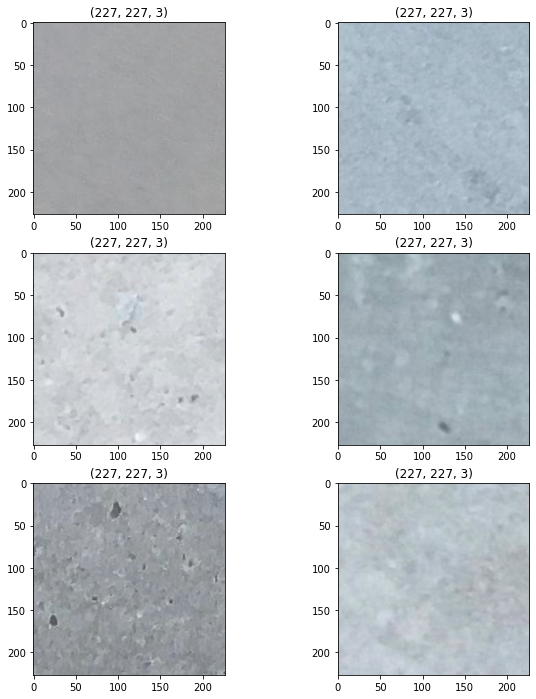

In [ ]:
load_images_from_folder("./archive/Negative/")

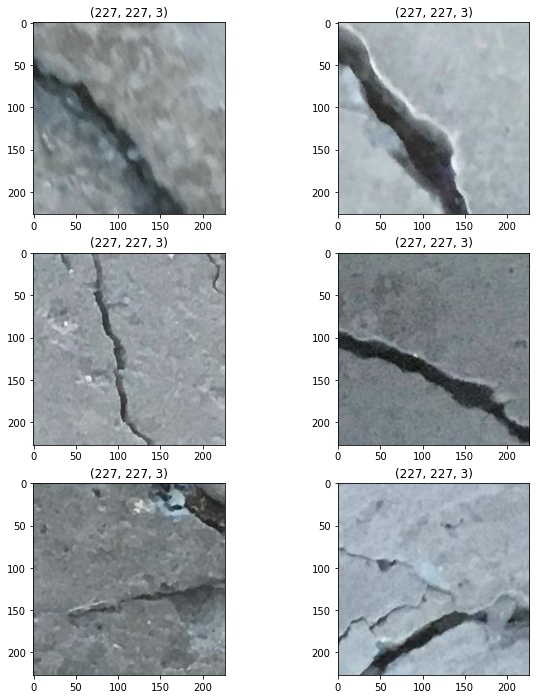

In [ ]:
load_images_from_folder("./archive/Positive/")

In [ ]:
# Make a dataframe based on the filenames
df_neg = pd.DataFrame(negative_dir, columns = ["filename"])
df_pos = pd.DataFrame(positive_dir, columns = ["filename"])


# Add Class columns 
df_neg['class'] = pd.Series([0 for x in range(len(df_neg.index))], index=df_neg.index)
df_pos['class'] = pd.Series([1 for x in range(len(df_pos.index))], index=df_pos.index)

# Concat both dataframes (negative & positive) & Shuffle
df_final = pd.concat([df_neg, df_pos], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=np.true_divide)
df_final['class'] = df_final['class'].astype(str)


In [ ]:
df_final.head()

,filename,class
0,./archive/Positive/03972.jpg,1
1,./archive/Negative/14869.jpg,0
2,./archive/Positive/05873.jpg,1
3,./archive/Negative/11130.jpg,0
4,./archive/Positive/11397_1.jpg,1


1    20000
0    20000
Name: class, dtype: int64


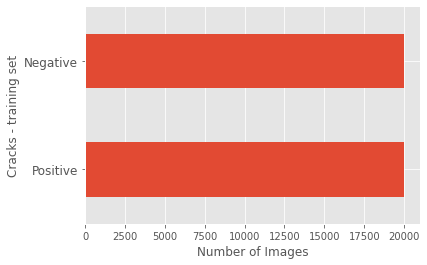

In [ ]:
# Examine the data
print(df_final['class'].value_counts())


ax = df_final['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Images", fontsize=12)
ax.set_ylabel("Cracks - training set", fontsize=12)
ax.set_yticklabels(['Positive','Negative'], rotation=0, fontsize=12)
plt.show()

In [ ]:
 # Train-test split the data 80-20
 train_df, test_df = train_test_split(
     df_final.sample(40000, random_state=42),
     train_size=0.8,
     shuffle=True,
     random_state=42
 )

## Load Image Data using ImageDataGenerator

- As our original images consist in RGB coefficients in the 0-255, but such value too high for our model to process, so we target values between 0-1 by scaling with a 1/255 factor. [reference](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

- validation spilit of 20%

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 # do not include validation split
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False, # do not shuffle the test
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


Therefore, a total of 25600 images of cracks and non cracks are used for training, 6400 images are used for validation and lastly, 8000 images are used for testing/predictions.

## Modeling - Convolutional Neural Network (CNN) Model

CNN is a type of artificial neural network, they are specifically designed to process pixel data and are widely used for image/object recognition and classification. 

A typical CNN model will have a convolutional base with a stack of Conv2D and MaxPooling2D layers followed by a GlobalAveragePooling2D/Flatten layer and then add a dense on top.

In [ ]:
inputs = Input(shape=(128, 128, 3))
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#Dense
x = GlobalAveragePooling2D()(x) # or do flattening
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_cnn = Model(inputs=inputs, outputs=outputs)

print(model_cnn.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248

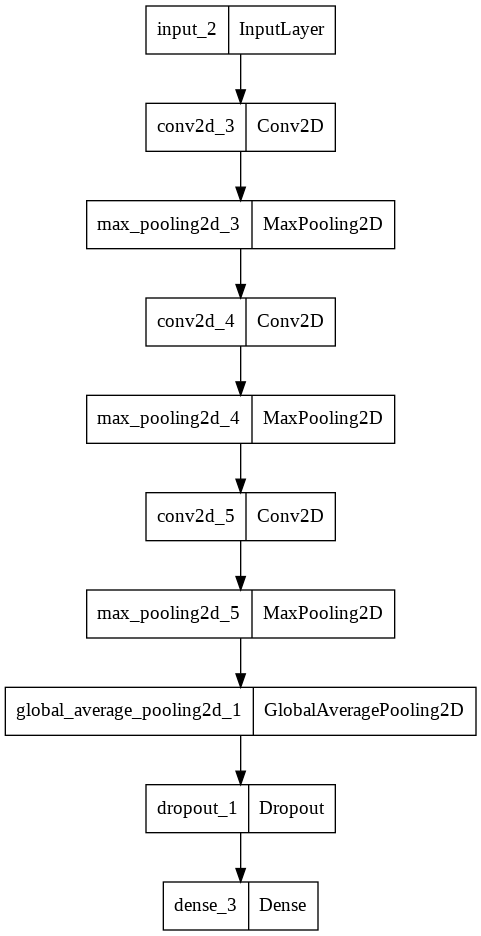

In [ ]:
plot_model(model_cnn, to_file = "drive/MyDrive/Colab Notebooks/img/CNN_model.png")

In [ ]:
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_cnn = model_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/CNN_model_history.csv')
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9328
Epoch 1: val_loss improved from inf to 0.07572, saving model to drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep01_val0.08.hdf5
800/800 [==============================] - 54s 56ms/step - loss: 0.2049 - accuracy: 0.9328 - val_loss: 0.0757 - val_accuracy: 0.9717
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9762
Epoch 2: val_loss improved from 0.07572 to 0.06054, saving model to drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep02_val0.06.hdf5
800/800 [==============================] - 43s 54ms/step - loss: 0.0935 - accuracy: 0.9762 - val_loss: 0.0605 - val_accuracy: 0.9800
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9793
Epoch 3: val_loss did not improve from 0.06054
800/800 [==============================] - 41s 51ms/step - loss: 0.0834 - accuracy: 0.9793 - val_loss: 0.0821 - val_accuracy: 0.9698
Epo

In [ ]:
cnn_history_df = pd.read_csv('drive/MyDrive/Colab Notebooks/checkpoints/CNN_model_history.csv')
cnn_history_df[cnn_history_df['epoch']==27]

,epoch,accuracy,loss,val_accuracy,val_loss
27,27,0.993633,0.021387,0.995781,0.016248


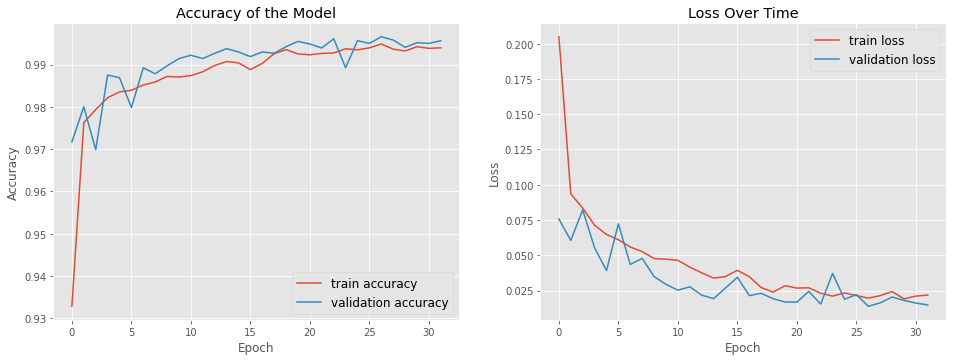

In [ ]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss Over Time')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})


In [ ]:
# Evaluation of Model

def evaluate_model(model, test_data, prefix=''):
  results = model.evaluate(test_data, verbose=0)
  loss = results[0]
  acc = results[1]
  print("Test Loss: {:.5f}".format(loss))
  print("Test Accuracy: {:.2f}".format(acc*100))

  y_pred = np.squeeze(model.predict(test_data)>=0.5).astype(int)
  cm = confusion_matrix(test_data.labels, y_pred)
  clr = classification_report(test_data.labels, y_pred, target_names=['Negative', 'Positive'])

  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive']) # get ticks in the middle of the boxes
  plt.yticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix - "+prefix)
  plt.show()

  print("Classification Report: \n ----------------------\n", clr)

Test Loss: 0.01201
Test Accuracy: 99.67
250/250 [==============================] - 11s 45ms/step


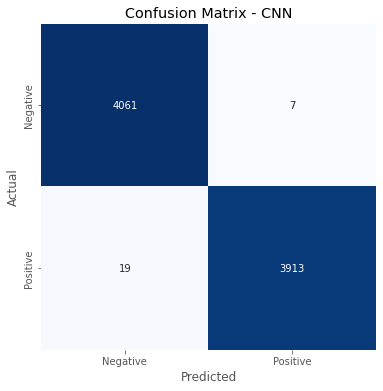

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4068
    Positive       1.00      1.00      1.00      3932

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
evaluate_model(model_cnn, test_data, prefix='CNN')

### Identify misclassified images

In [ ]:
y_pred_cnn = np.squeeze(model_cnn.predict(test_data)>=0.5).astype(int)

250/250 [==============================] - 10s 39ms/step


In [ ]:
test_df_misclassified = test_df
test_df_misclassified['predicted'] = y_pred_cnn.tolist()
test_df_misclassified['class'] = test_df_misclassified['class'].astype(int)

In [ ]:
test_df_misclassified.loc[test_df_misclassified['class']!=test_df_misclassified['predicted']]

,filename,class,predicted
16355,./archive/Positive/19454.jpg,1,0
7738,./archive/Positive/04231.jpg,1,0
27036,./archive/Positive/14511_1.jpg,1,0
37672,./archive/Negative/14979.jpg,0,1
8313,./archive/Positive/13607_1.jpg,1,0
26385,./archive/Negative/04080.jpg,0,1
18148,./archive/Positive/18036_1.jpg,1,0
8597,./archive/Positive/16550_1.jpg,1,0
37110,./archive/Positive/16471_1.jpg,1,0
18904,./archive/Positive/16946_1.jpg,1,0


## Modeling - Transfer Learning (VGG16)

In [ ]:
train_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    validation_split = 0.2
)

test_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

In [ ]:
train_data_vgg = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), # vgg16 default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_vgg = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_vgg = train_gen_mobile.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [ ]:
# Download feature extractor

feature_extractor = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
last_layer = feature_extractor.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=feature_extractor.inputs, outputs=outputs)

print(model_vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

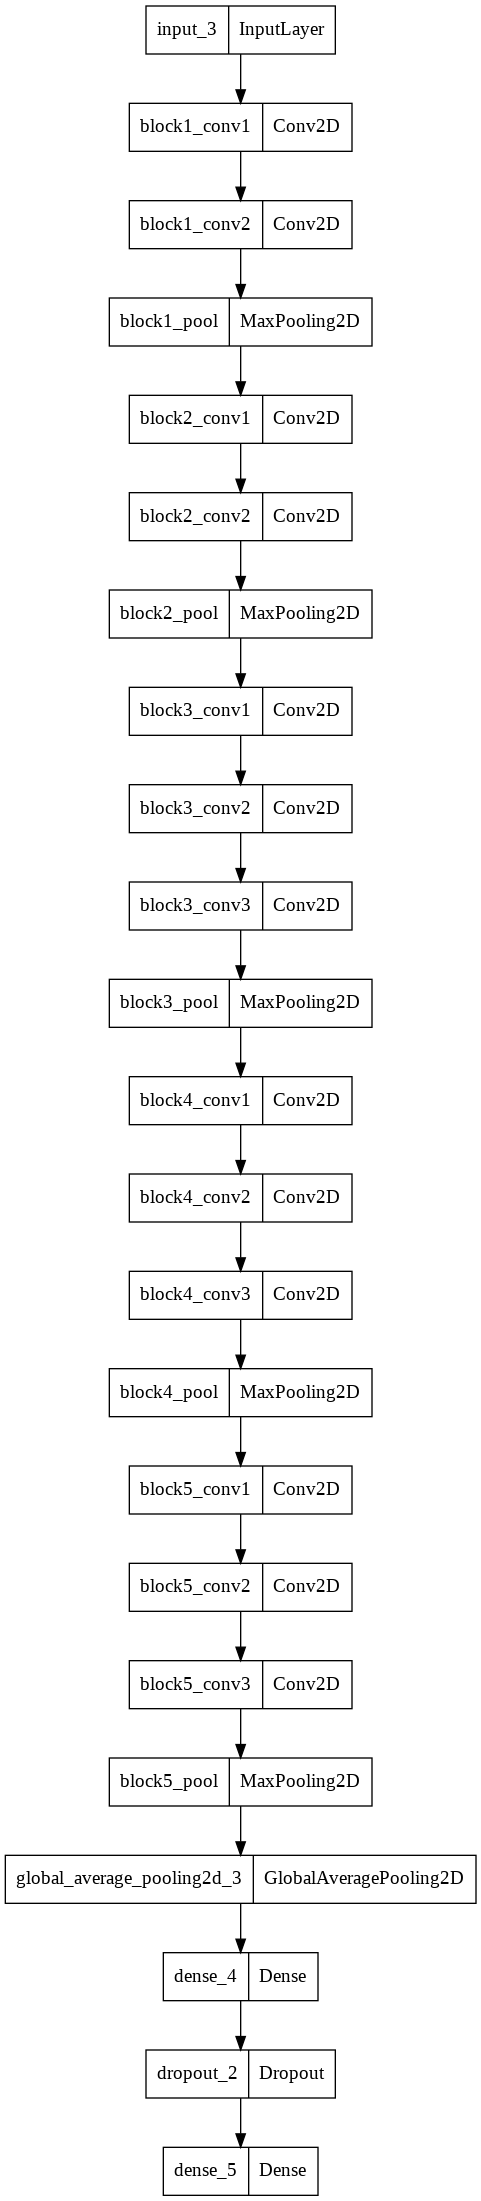

In [ ]:
plot_model(model_vgg, to_file = "drive/MyDrive/Colab Notebooks/img/TF_VGG16_model.png")

In [ ]:
model_vgg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model

history_vgg = model_vgg.fit(
    train_data_vgg,
    validation_data = val_data_vgg,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/VGG16_model_history.csv')
        
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9948
Epoch 1: val_loss improved from inf to 0.00669, saving model to drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep01_val0.01.hdf5
800/800 [==============================] - 164s 201ms/step - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.0067 - val_accuracy: 0.9984
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9976
Epoch 2: val_loss did not improve from 0.00669
800/800 [==============================] - 159s 198ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.0085 - val_accuracy: 0.9981
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9983
Epoch 3: val_loss improved from 0.00669 to 0.00514, saving model to drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep03_val0.01.hdf5
800/800 [==============================] - 159s 198ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 

In [ ]:
vgg_history_df = pd.read_csv('drive/MyDrive/Colab Notebooks/checkpoints/VGG16_model_history.csv')
vgg_history_df[vgg_history_df['epoch']==3]

,epoch,accuracy,loss,val_accuracy,val_loss
3,3,0.998359,0.005318,0.998594,0.005518


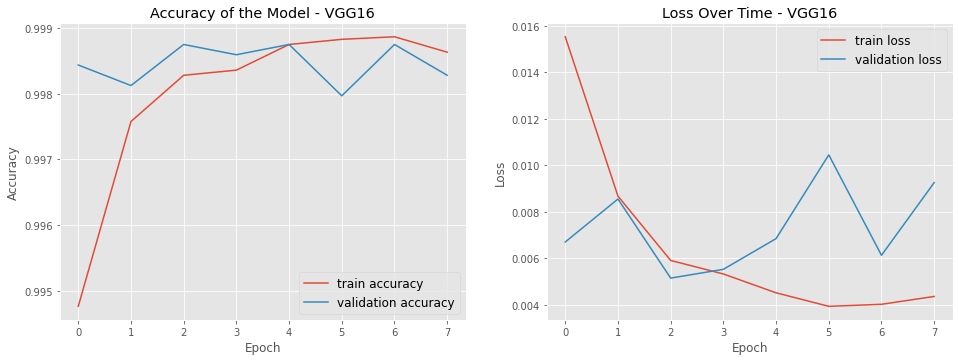

In [ ]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Accuracy of the Model - VGG16')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss Over Time - VGG16')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

Test Loss: 0.00467
Test Accuracy: 99.90
250/250 [==============================] - 38s 153ms/step


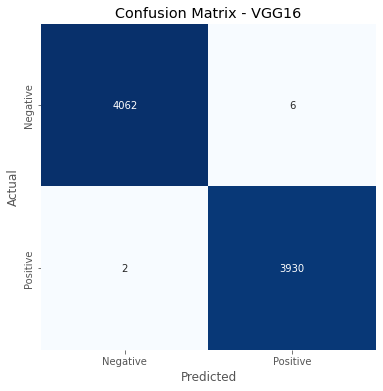

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4068
    Positive       1.00      1.00      1.00      3932

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
evaluate_model(model_vgg, test_data_vgg, prefix='VGG16')

### Identify misclassified images

In [ ]:
y_pred_vgg = np.squeeze(model_vgg.predict(test_data_vgg)>=0.5).astype(int)

250/250 [==============================] - 40s 160ms/step


In [ ]:
test_df_misclassified_vgg = test_df
test_df_misclassified_vgg['predicted'] = y_pred_vgg.tolist()
test_df_misclassified_vgg['class'] = test_df_misclassified_vgg['class'].astype(int)

In [ ]:
test_df_misclassified_vgg.loc[test_df_misclassified_vgg['class']!=test_df_misclassified_vgg['predicted']]

,filename,class,predicted
3115,./archive/Positive/13253_1.jpg,1,0
3835,./archive/Negative/16324.jpg,0,1
32187,./archive/Negative/00463.jpg,0,1
8313,./archive/Positive/13607_1.jpg,1,0
20808,./archive/Negative/06135.jpg,0,1
14416,./archive/Negative/01109.jpg,0,1
27926,./archive/Negative/15518.jpg,0,1
26051,./archive/Negative/11352.jpg,0,1


## Modeling - Transfer Learning (InceptionV3)

In [ ]:
train_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
    validation_split = 0.2
)

test_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

In [ ]:
train_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), # inceptionv3 default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_incep = train_gen_incep.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [ ]:
# Download feature extractor

feature_extractor_incep = tf.keras.applications.InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor_incep.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# We will use the part of the pre_trained model from input later until the layer 'mixed10'
# You can also choose different layer for starting
last_layer = feature_extractor_incep.get_layer('mixed10') 
last_output = last_layer.output

#takes a average pooling in a way that flattenning an amount
x = GlobalAveragePooling2D()(last_output)
x = Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)  
outputs = Dense(1, activation='sigmoid')(x)   

model_incep = Model(inputs=feature_extractor_incep.inputs, outputs=outputs)

print(model_incep.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_6[0][0]']               
 alization)                     )                                                           

In [ ]:
model_incep.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model

history_incep = model_incep.fit(
    train_data_incep,
    validation_data = val_data_incep,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/incepV3_model_history.csv')
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9939
Epoch 1: val_loss improved from inf to 0.01183, saving model to drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep01_val0.01.hdf5
800/800 [==============================] - 136s 163ms/step - loss: 0.0209 - accuracy: 0.9939 - val_loss: 0.0118 - val_accuracy: 0.9970
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9975
Epoch 2: val_loss did not improve from 0.01183
800/800 [==============================] - 127s 159ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.0138 - val_accuracy: 0.9969
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9981
Epoch 3: val_loss improved from 0.01183 to 0.01033, saving model to drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep03_val0.01.hdf5
800/800 [==============================] - 129s 161ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.0103 - val_accura

In [ ]:
incep_history_df = pd.read_csv('drive/MyDrive/Colab Notebooks/checkpoints/incepV3_model_history.csv')
incep_history_df[incep_history_df['epoch']==7]

,epoch,accuracy,loss,val_accuracy,val_loss
7,7,0.998828,0.003779,0.994687,0.021468


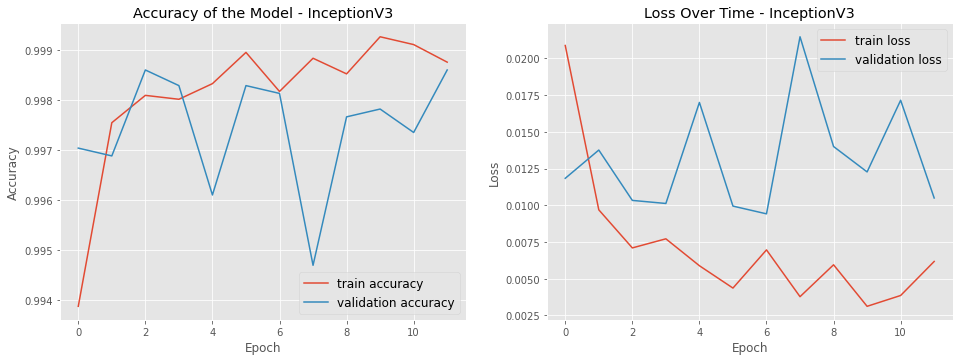

In [ ]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_incep.history['accuracy'])
plt.plot(history_incep.history['val_accuracy'])
plt.title('Accuracy of the Model - InceptionV3')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_incep.history['loss'])
plt.plot(history_incep.history['val_loss'])
plt.title('Loss Over Time - InceptionV3')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

Test Loss: 0.00228
Test Accuracy: 99.92
250/250 [==============================] - 31s 121ms/step


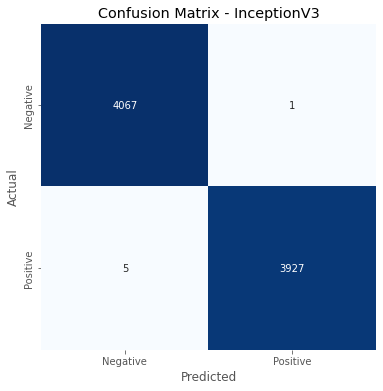

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4068
    Positive       1.00      1.00      1.00      3932

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [ ]:
evaluate_model(model_incep, test_data_incep, prefix='InceptionV3')

### Identify misclassified images

In [ ]:
y_pred_incep = np.squeeze(model_incep.predict(test_data_incep)>=0.5).astype(int)

250/250 [==============================] - 32s 127ms/step


In [ ]:
test_df_misclassified_incep = test_df
test_df_misclassified_incep['predicted'] = y_pred_incep.tolist()
test_df_misclassified_incep['class'] = test_df_misclassified_incep['class'].astype(int)

In [ ]:
test_df_misclassified_incep.loc[test_df_misclassified_incep['class']!=test_df_misclassified_incep['predicted']]

,filename,class,predicted
11348,./archive/Positive/04012.jpg,1,0
12746,./archive/Negative/11684.jpg,0,1
8313,./archive/Positive/13607_1.jpg,1,0
8888,./archive/Positive/07122.jpg,1,0
29803,./archive/Positive/04987.jpg,1,0
16183,./archive/Positive/13177_1.jpg,1,0


## Model Evaluation

Model | loss | val_loss | test_loss | train_accuracy | val_accuracy | test_accuracy|
--------|-----|-----|-----|-----|-----|-----|
CNN                           | 0.0214 | 0.0163 | 0.0120 | 99.36% | 99.58% | 99.67% |
Transfer-Learning VGG16       | 0.0053 | 0.0055 | 0.0047 | 99.84% | 99.86% | 99.90% |
Transfer-Learning InceptionV3 | 0.0038 | 0.0215 | 0.0023 | 99.88% | 99.47% | 99.92% |

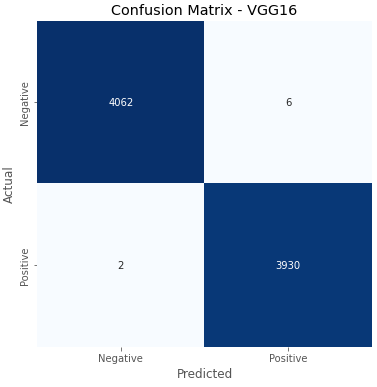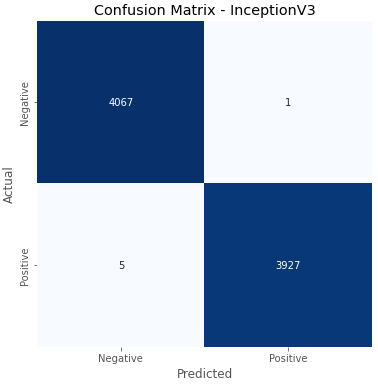

Generally, all three models are performing well with an accuracy of above 95%, with a slight underfitting of models (consider reducing the training set e.g 80-20 split to 70-30). Transfer learning model using VGG16 seems to perform the best with the smallest generalisation between training loss and validation loss, train and validation accuracy. Therefore, even though InceptionV3 has the highest test accuracy, VGG16 model is preferred with a slight compromisation in test accuracy of 0.02% in comparision with InceptionV3 test accuracy. In additional, VGG16 model predicts less false negative images as compared inceptionV3 model. 

### Looking at some of the misclassified images

For VGG16 model, these are the images with cracks yet model predicted it as no cracks.

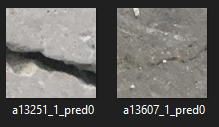

It seems like the model failed to capture the crack line or pattern in these images.

And these are the images without cracks and yet classified as with cracks.

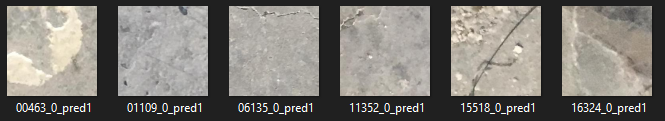

From the above images that are misclassified as with cracks, the model seems to capture the line shape feature in the images as cracks. For example, for image 15518, the line is well defined but it does not looks like a crack line. It seems more like the surface of the concrete being vandalised by something sharp. Whereas for image 06135 and 11352, the model is able to capture the fine crack line at the top of the image for 06135 and left top of the image for 11352. These images could have already been misclassified in the dataset provided.

### Make some predictions

Let us make some prediction of images that are not contained in the dataset provided.

In [ ]:
!wget -qq https://www.dropbox.com/s/obr99r8s1hj781k/test_images.zip
!unzip -qq test_images.zip
!rm test_images.zip

!ls

replace test_images/colonial_theatre_crack_facade_test.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test_images/cracked_concrete_driveway_cracks.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
archive  drive	model.png  sample_data	test_images


In [ ]:
!ls test_images

colonial_theatre_crack_facade_test.jpg	road_crack_test.jfif
cracked_concrete_driveway_cracks.jpg	road_crack_test.jpg


In [ ]:
image_path = './test_images/'

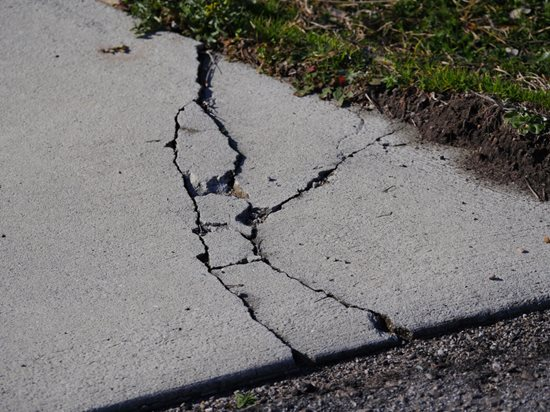

In [ ]:
from IPython.display import Image

image_name = 'cracked_concrete_driveway_cracks.jpg'
Image(image_path+image_name)

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model_vgg.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

1/1 [==============================] - 1s 848ms/step
Predicted: [[0.99990153]]
0


In [ ]:
result= pred[0][0]
if result>= 0.5:
    print("Cracks")
else:
    print("no cracks")

Cracks


The above image is a concrete driveway crack and VGG16 model successfully identified that there is crack in the concrete.

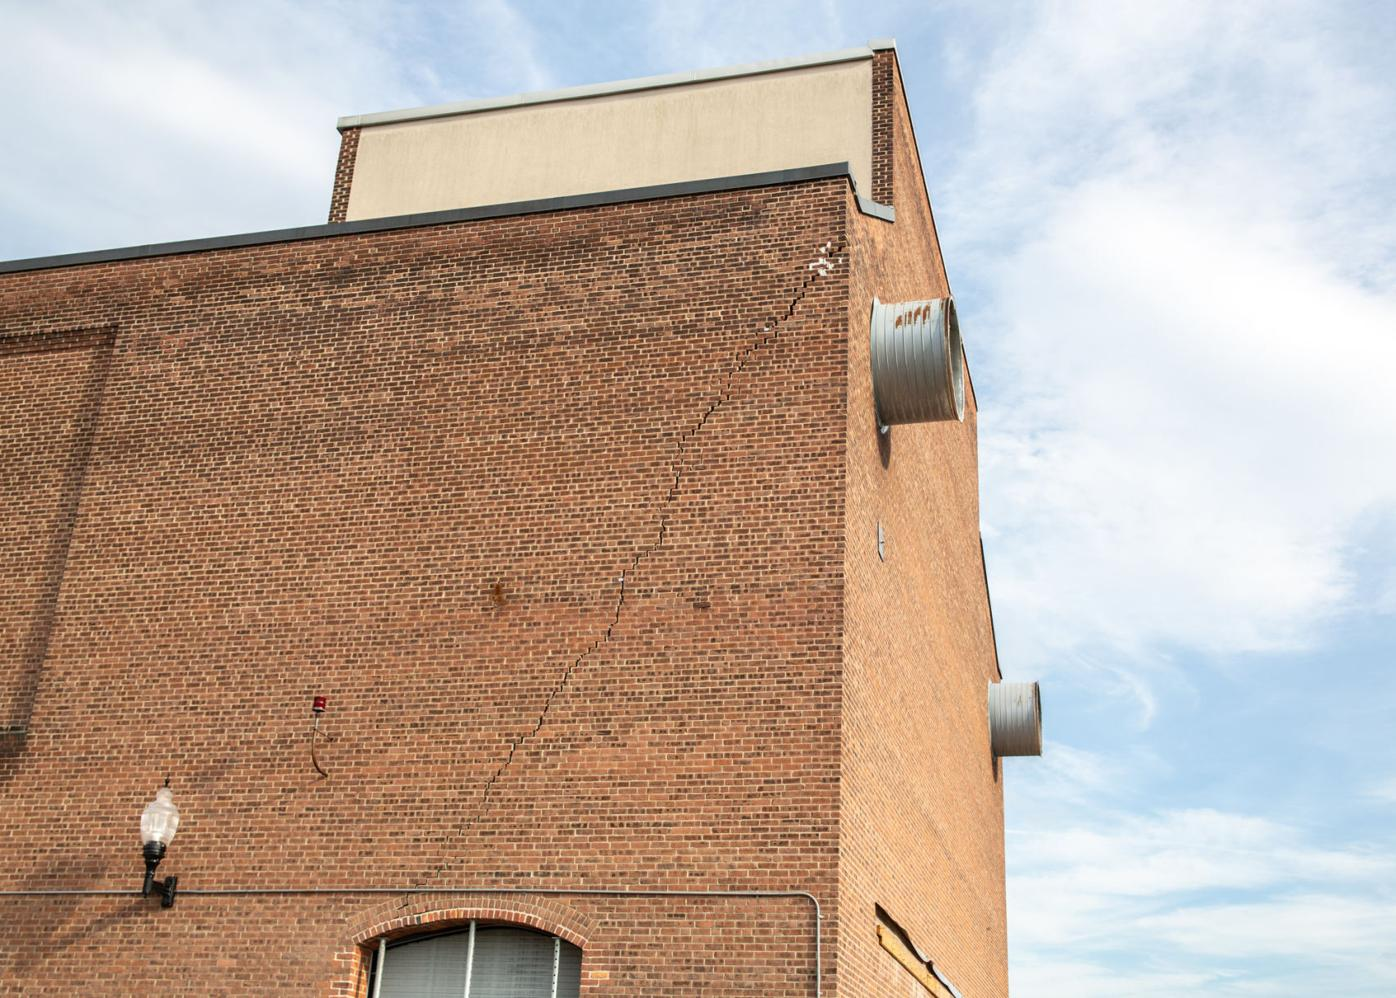

In [ ]:
image_name = 'colonial_theatre_crack_facade_test.jpg'
Image(image_path+image_name)

In [ ]:
img_path = os.path.join(image_path, image_name)
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model_vgg.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

1/1 [==============================] - 0s 26ms/step
Predicted: [[3.572556e-22]]
0


In [ ]:
result= pred[0][0]
if result>= 0.5:
    print("Cracks")
else:
    print("no cracks")

no cracks


This image is an image of the Colonial Theatre with facade cracks. The model failed to identify the crack in the facade. Possible reasons could be:
1. the training dataset is close-up images of concrete with and without cracks. In additional, high resolution images are found to have high variance in terms of surface finish and illumination condition.
2. model cannot identify cracks in facade or crack in building built with bricks

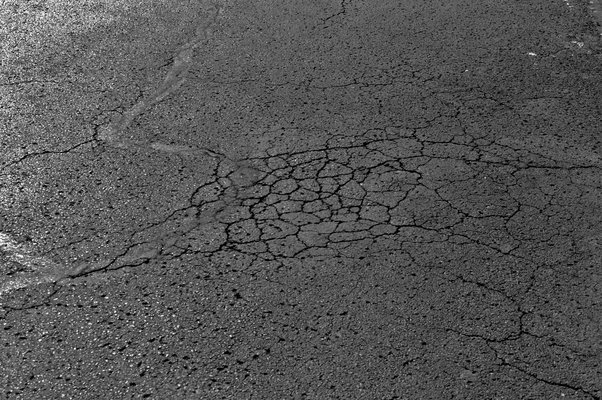

In [ ]:
image_name = 'road_crack_test.jpg'
Image(image_path+image_name)

In [ ]:
img_path = os.path.join(image_path, image_name)
img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model_vgg.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

1/1 [==============================] - 0s 21ms/step
Predicted: [[5.39434e-05]]
0


In [ ]:
result= pred[0][0]
if result>= 0.5:
    print("Cracks")
else:
    print("no cracks")

no cracks


This image is an image of road cracks in asphalt. The model failed to identify the crack. Possible reasons could be:
1. the training dataset contains close-up images of concrete with and without cracks. In additional, high resolution images are found to have high variance in terms of surface finish and illumination condition.
2. Different material, crack pattern in asphalt is different from concrete which makes the model fail to identify cracks.

## Conclusion

In conclusion, all three models perform fairly well with accuracy of ~99%. Transfer learning model using VGG16 performs the best as it has the smallest generalisation between training loss and validation loss amount all three models. However it seems that the model could only predict cracks in concrete and close-up images of the cracks. The model could not predict 
1. high-resolution images for images of crack from afar (but these images can be divided into smaller pieces and identify whether crack exist)
2. Other non-concrete cracks such as cracks in facades or asphalt road



### Recommendation/future works

1. Predicting whether the the cracks are structural or non-structural cracks could be an interesting topic to research on as this will help people to identify whether the cracks will affect the structural integrity of the building or determine whether the building is under-designed. Datasets should include images of structural cracks and usually these are not close up images. Location of the crack is needed to determine whether there are structural cracks and type of structural cracks -- be it cracks formed on the beam, column, wall or slab. 

2. Modern buildings comes with different kind of facades, most commonly glass, steel facades. We might also want to research on the cracks in these facades of different material from concrete. However, do take note that green facades might affect model's prediction and look into how to overcome the difficulty in identify cracks for building with green facades.

In [ ]:
# kill the VM and restart Colab with a new machine
!kill -9 -1